# Notebook to plot results from deblurring

[INFO] Image+CLIP: found 192 metrics files
[INFO] Image-only: found 192 metrics files
[INFO] Random init: found 192 metrics files
[INFO] Loaded total 1152 PSNR datapoints
[INFO] Datatypes: ['amyloid_plaque_patches', 'c_fos_positive_patches', 'cell_nucleus_patches', 'vessels_patches']


,series,subtype,train_size,metric,csv_path
0,Image+CLIP,amyloid_plaque_patches,10,19.1584,/midtier/paetzollab/scratch/ads4015/temp_selma...
1,Image+CLIP,amyloid_plaque_patches,10,30.3847,/midtier/paetzollab/scratch/ads4015/temp_selma...
2,Image+CLIP,amyloid_plaque_patches,11,31.3671,/midtier/paetzollab/scratch/ads4015/temp_selma...
3,Image+CLIP,amyloid_plaque_patches,11,19.3085,/midtier/paetzollab/scratch/ads4015/temp_selma...
4,Image+CLIP,amyloid_plaque_patches,12,18.1466,/midtier/paetzollab/scratch/ads4015/temp_selma...


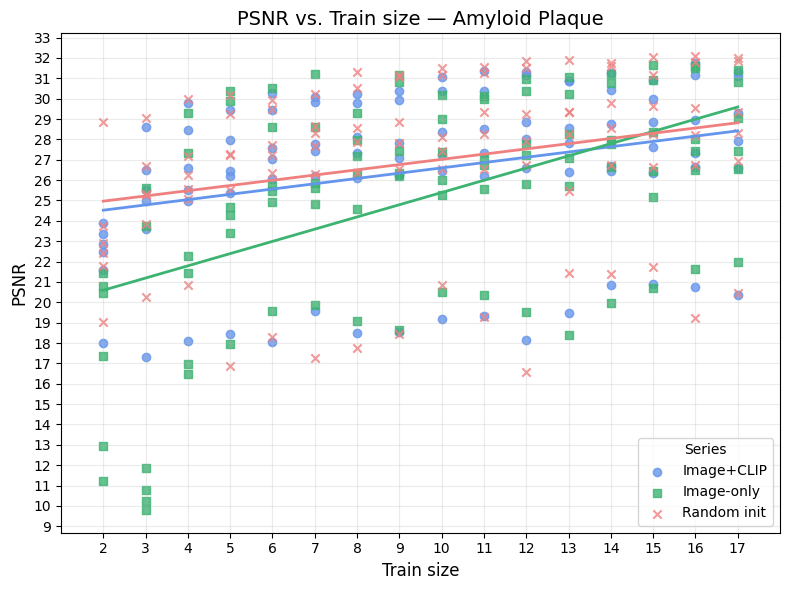

/tmp/ipykernel_546663/1050545505.py:160: RankWarning: Polyfit may be poorly conditioned
  a, b = np.polyfit(x, y, 1)
/tmp/ipykernel_546663/1050545505.py:160: RankWarning: Polyfit may be poorly conditioned
  a, b = np.polyfit(x, y, 1)
/tmp/ipykernel_546663/1050545505.py:160: RankWarning: Polyfit may be poorly conditioned
  a, b = np.polyfit(x, y, 1)


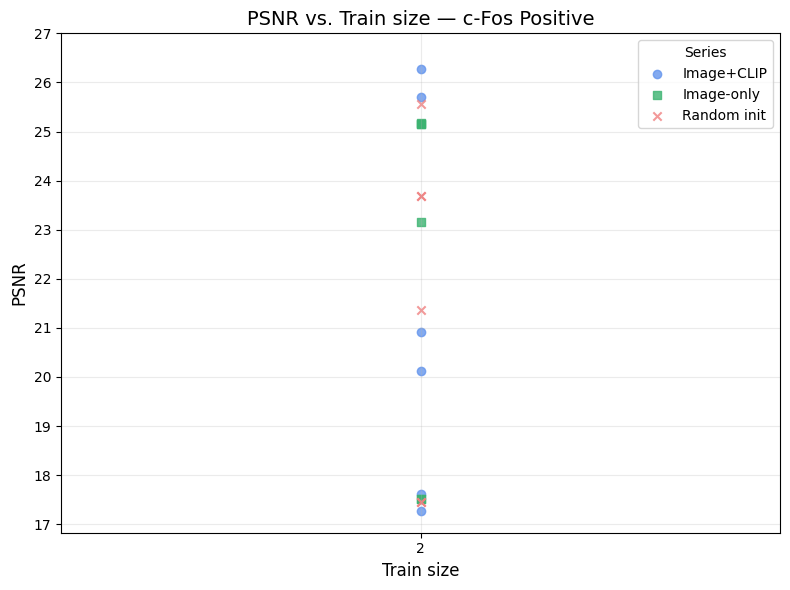

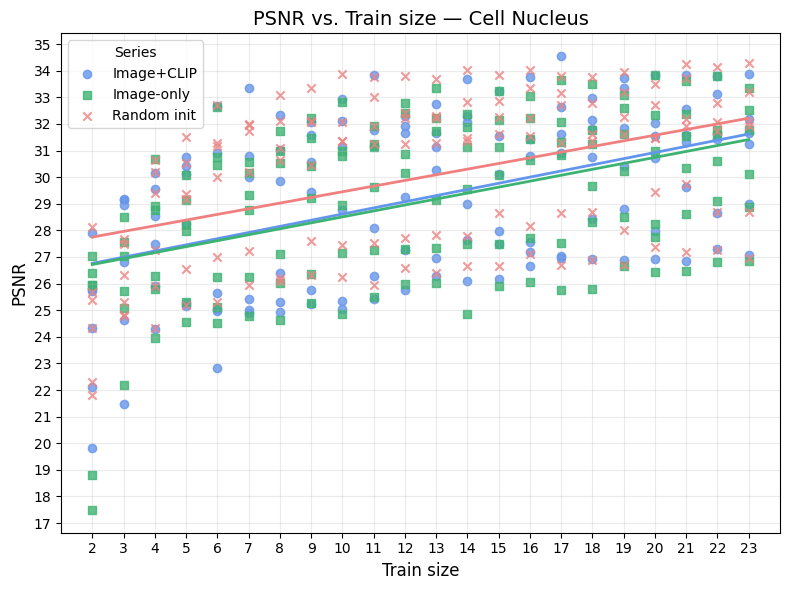

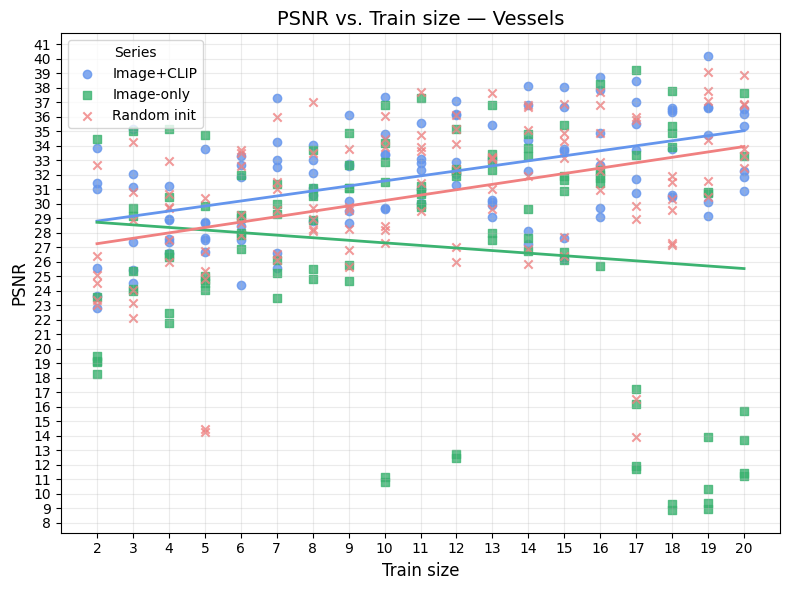

In [1]:
# ============================================================
# UPDATED DEBLURRING PSNR PLOTTING WITH CONFIGURABLE X-RANGES
# ============================================================

import re
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --------------------------------------------------
# 1. CONFIGURATION
# --------------------------------------------------

RESULT_SETS = [
    ("Image+CLIP", "/midtier/paetzollab/scratch/ads4015/temp_selma_deblur_preds_autumn_sweep_27/preds"),
    ("Image-only", "/midtier/paetzollab/scratch/ads4015/temp_selma_deblur_preds_expert_sweep_31/preds"),
    ("Random init", "/midtier/paetzollab/scratch/ads4015/temp_selma_deblur_preds_random/preds"),
]

METRIC_COL = "psnr"

COLOR_MAP = {
    "Image+CLIP": "cornflowerblue",
    "Image-only": "mediumseagreen",
    "Random init": "lightcoral",
}

MARKER_MAP = {
    "Image+CLIP": "o",
    "Image-only": "s",
    "Random init": "x",
}

# -------------------------------
# Pretty names for datatypes
# -------------------------------
PRETTY_NAME = {
    "amyloid_plaque_patches": "Amyloid Plaque",
    "c_fos_positive_patches": "c-Fos Positive",
    "cell_nucleus_patches": "Cell Nucleus",
    "vessels_patches": "Vessels",
}

# --------------------------------------------------
#  X-axis configurations per datatype (train size)
# --------------------------------------------------
XRANGES = {
    "amyloid_plaque_patches": (2, 17),
    "c_fos_positive_patches": (2, 2),
    "cell_nucleus_patches": (2, 23),
    "vessels_patches": (2, 20),
}

XBUFFER = 1   # how much buffer on each side of the axis


# --------------------------------------------------
# 2. LOAD DATA FROM ALL metrics_test.csv FILES
# --------------------------------------------------

rows = []

for label, root in RESULT_SETS:
    root = Path(root)

    if not root.exists():
        print(f"[WARN] Skipping missing path: {root}")
        continue

    csv_paths = sorted(root.rglob("metrics_test.csv"))
    print(f"[INFO] {label}: found {len(csv_paths)} metrics files")

    for csv_path in csv_paths:

        # Extract train size from trlim
        m = re.search(r"trlim(\d+)", str(csv_path))
        if not m:
            print(f"[WARN] No trlim found in {csv_path}")
            continue
        train_size = int(m.group(1))

        # Determine subtype (datatype)
        parts = csv_path.parts
        try:
            idx = parts.index("preds")
            subtype = parts[idx + 1]
        except ValueError:
            subtype = "unknown"

        # Load metrics
        df = pd.read_csv(csv_path)
        if METRIC_COL not in df.columns:
            print(f"[WARN] {METRIC_COL} missing in {csv_path}")
            continue

        # Append ALL INDIVIDUAL PSNR values
        for val in df[METRIC_COL].astype(float).tolist():
            rows.append({
                "series": label,
                "subtype": subtype,
                "train_size": train_size,
                "metric": float(val),
                "csv_path": str(csv_path),
            })

data = pd.DataFrame(rows)
print(f"[INFO] Loaded total {len(data)} PSNR datapoints")
print("[INFO] Datatypes:", sorted(data["subtype"].unique()))
display(data.head())


# --------------------------------------------------
# 3. PLOTTING — One figure per datatype
# --------------------------------------------------

for subtype in sorted(data["subtype"].unique()):

    sub_df = data[data["subtype"] == subtype].copy()

    if sub_df.empty:
        continue

    # ------------------------------
    # GET PRETTY NAME + X-RANGE
    # ------------------------------
    pretty = PRETTY_NAME.get(subtype, subtype.replace("_", " ").title())
    xmin_conf, xmax_conf = XRANGES.get(subtype, (sub_df["train_size"].min(), sub_df["train_size"].max()))

    # Filter points to the configured range
    plot_df = sub_df[(sub_df["train_size"] >= xmin_conf) &
                     (sub_df["train_size"] <= xmax_conf)].copy()

    if plot_df.empty:
        print(f"[WARN] No points for {subtype} in configured range")
        continue

    plt.figure(figsize=(8, 6))

    # --------------------------
    # PLOT DATA
    # --------------------------
    for series in plot_df["series"].unique():
        df_s = plot_df[plot_df["series"] == series]

        # Scatter all test points
        plt.scatter(
            df_s["train_size"],
            df_s["metric"],
            color=COLOR_MAP[series],
            marker=MARKER_MAP[series],
            alpha=0.8,
            label=series
        )

        # Regression line
        x = df_s["train_size"].values
        y = df_s["metric"].values
        if len(df_s) > 1:
            a, b = np.polyfit(x, y, 1)
            xs = np.linspace(x.min(), x.max(), 200)
            ys = a * xs + b
            plt.plot(xs, ys, color=COLOR_MAP[series], linewidth=2)

    # --------------------------
    # AXIS FORMATTING
    # --------------------------

    # X-axis ticks: every integer in range
    xticks = np.arange(xmin_conf, xmax_conf + 1)
    plt.xticks(xticks)

    # Add buffer to axis limits
    plt.xlim(xmin_conf - XBUFFER, xmax_conf + XBUFFER)

    # Y-axis: ticks at EVERY integer
    ymin, ymax = plot_df["metric"].min(), plot_df["metric"].max()
    ymin_int = int(np.floor(ymin))
    ymax_int = int(np.ceil(ymax))
    plt.yticks(np.arange(ymin_int, ymax_int + 1, 1))

    # Labels + title
    plt.xlabel("Train size", fontsize=12)
    plt.ylabel("PSNR", fontsize=12)
    plt.title(f"PSNR vs. Train size — {pretty}", fontsize=14)

    plt.legend(title="Series")
    plt.grid(True, alpha=0.25)
    plt.tight_layout()
    plt.show()


In [ ]:
## UP TO HERE - waiting for blurrier results to finish then will plot below and see which are better

[INFO] Image+CLIP: found 192 metrics files
[INFO] Image-only: found 53 metrics files
[INFO] Random init: found 192 metrics files
[INFO] Loaded total 874 PSNR datapoints
[INFO] Datatypes: ['amyloid_plaque_patches', 'c_fos_positive_patches', 'cell_nucleus_patches', 'vessels_patches']


,series,subtype,train_size,metric,csv_path
0,Image+CLIP,amyloid_plaque_patches,10,18.6191,/midtier/paetzollab/scratch/ads4015/temp_selma...
1,Image+CLIP,amyloid_plaque_patches,10,28.0971,/midtier/paetzollab/scratch/ads4015/temp_selma...
2,Image+CLIP,amyloid_plaque_patches,11,27.9858,/midtier/paetzollab/scratch/ads4015/temp_selma...
3,Image+CLIP,amyloid_plaque_patches,11,19.1165,/midtier/paetzollab/scratch/ads4015/temp_selma...
4,Image+CLIP,amyloid_plaque_patches,12,18.6397,/midtier/paetzollab/scratch/ads4015/temp_selma...


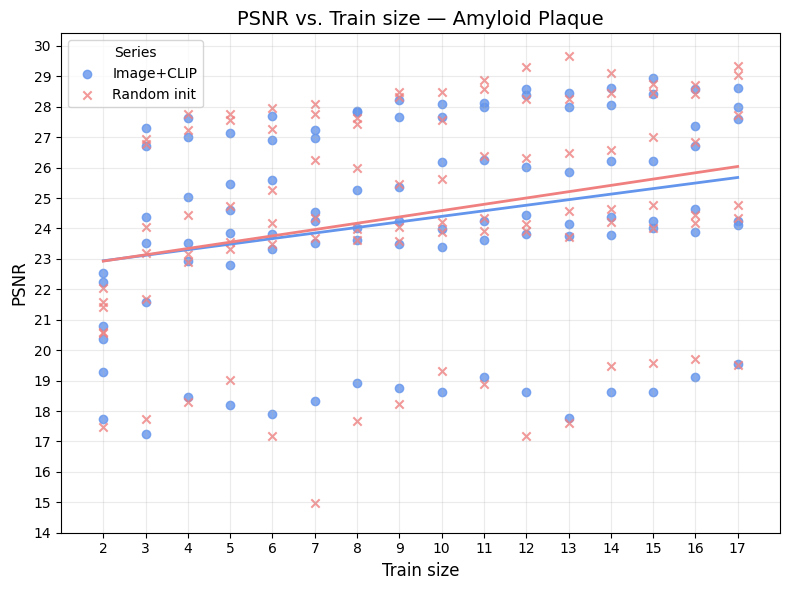

/tmp/ipykernel_546663/14381103.py:160: RankWarning: Polyfit may be poorly conditioned
  a, b = np.polyfit(x, y, 1)
/tmp/ipykernel_546663/14381103.py:160: RankWarning: Polyfit may be poorly conditioned
  a, b = np.polyfit(x, y, 1)


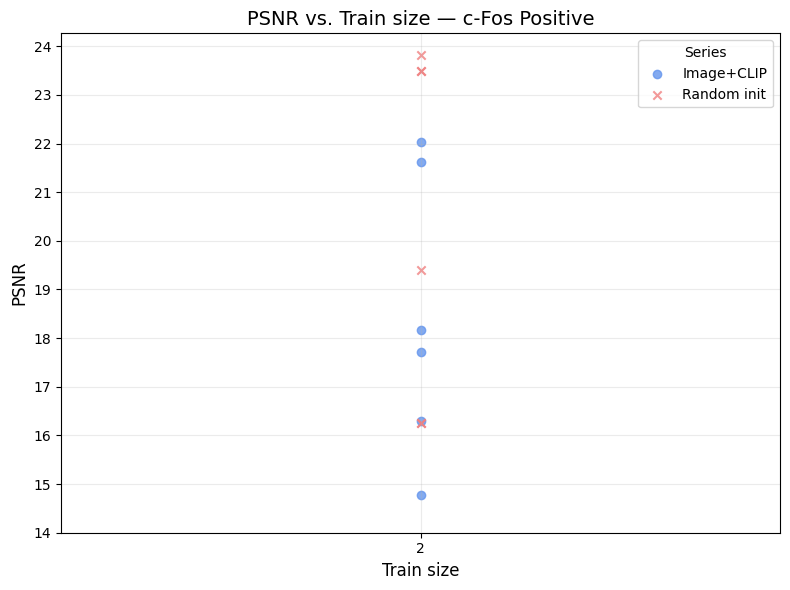

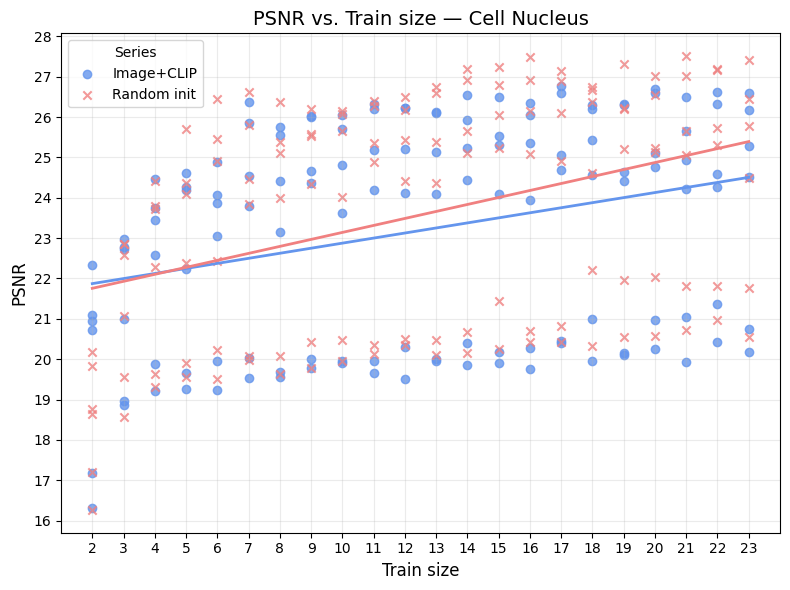

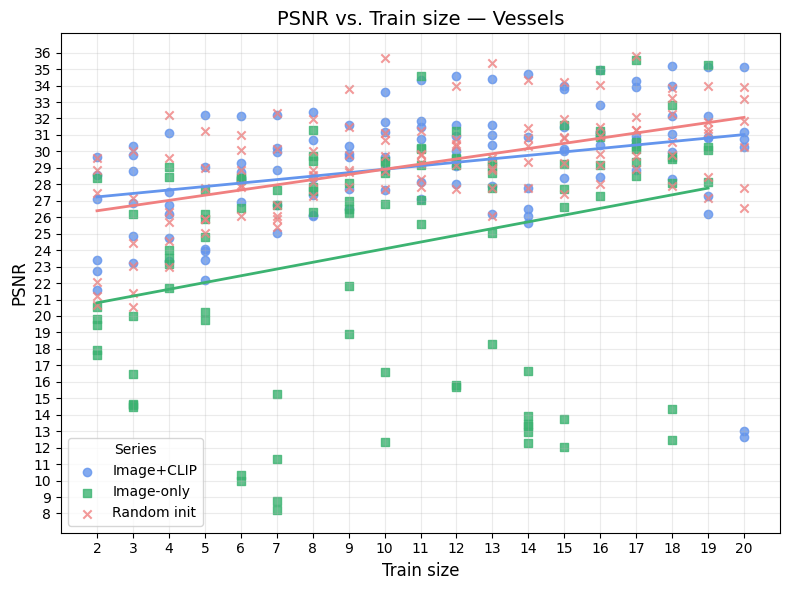

In [3]:
# ============================================================
# UPDATED DEBLURRING PSNR PLOTTING WITH CONFIGURABLE X-RANGES
# ============================================================

import re
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --------------------------------------------------
# 1. CONFIGURATION
# --------------------------------------------------

RESULT_SETS = [
    ("Image+CLIP", "/midtier/paetzollab/scratch/ads4015/temp_selma_deblur_preds_autumn_sweep_27_v2/preds"),
    ("Image-only", "/midtier/paetzollab/scratch/ads4015/temp_selma_deblur_preds_expert_sweep_31_v2/preds"),
    ("Random init", "/midtier/paetzollab/scratch/ads4015/temp_selma_deblur_preds_random_v2/preds"),
]

METRIC_COL = "psnr"

COLOR_MAP = {
    "Image+CLIP": "cornflowerblue",
    "Image-only": "mediumseagreen",
    "Random init": "lightcoral",
}

MARKER_MAP = {
    "Image+CLIP": "o",
    "Image-only": "s",
    "Random init": "x",
}

# -------------------------------
# Pretty names for datatypes
# -------------------------------
PRETTY_NAME = {
    "amyloid_plaque_patches": "Amyloid Plaque",
    "c_fos_positive_patches": "c-Fos Positive",
    "cell_nucleus_patches": "Cell Nucleus",
    "vessels_patches": "Vessels",
}

# --------------------------------------------------
#  X-axis configurations per datatype (train size)
# --------------------------------------------------
XRANGES = {
    "amyloid_plaque_patches": (2, 17),
    "c_fos_positive_patches": (2, 2),
    "cell_nucleus_patches": (2, 23),
    "vessels_patches": (2, 20),
}

XBUFFER = 1   # how much buffer on each side of the axis


# --------------------------------------------------
# 2. LOAD DATA FROM ALL metrics_test.csv FILES
# --------------------------------------------------

rows = []

for label, root in RESULT_SETS:
    root = Path(root)

    if not root.exists():
        print(f"[WARN] Skipping missing path: {root}")
        continue

    csv_paths = sorted(root.rglob("metrics_test.csv"))
    print(f"[INFO] {label}: found {len(csv_paths)} metrics files")

    for csv_path in csv_paths:

        # Extract train size from trlim
        m = re.search(r"trlim(\d+)", str(csv_path))
        if not m:
            print(f"[WARN] No trlim found in {csv_path}")
            continue
        train_size = int(m.group(1))

        # Determine subtype (datatype)
        parts = csv_path.parts
        try:
            idx = parts.index("preds")
            subtype = parts[idx + 1]
        except ValueError:
            subtype = "unknown"

        # Load metrics
        df = pd.read_csv(csv_path)
        if METRIC_COL not in df.columns:
            print(f"[WARN] {METRIC_COL} missing in {csv_path}")
            continue

        # Append ALL INDIVIDUAL PSNR values
        for val in df[METRIC_COL].astype(float).tolist():
            rows.append({
                "series": label,
                "subtype": subtype,
                "train_size": train_size,
                "metric": float(val),
                "csv_path": str(csv_path),
            })

data = pd.DataFrame(rows)
print(f"[INFO] Loaded total {len(data)} PSNR datapoints")
print("[INFO] Datatypes:", sorted(data["subtype"].unique()))
display(data.head())


# --------------------------------------------------
# 3. PLOTTING — One figure per datatype
# --------------------------------------------------

for subtype in sorted(data["subtype"].unique()):

    sub_df = data[data["subtype"] == subtype].copy()

    if sub_df.empty:
        continue

    # ------------------------------
    # GET PRETTY NAME + X-RANGE
    # ------------------------------
    pretty = PRETTY_NAME.get(subtype, subtype.replace("_", " ").title())
    xmin_conf, xmax_conf = XRANGES.get(subtype, (sub_df["train_size"].min(), sub_df["train_size"].max()))

    # Filter points to the configured range
    plot_df = sub_df[(sub_df["train_size"] >= xmin_conf) &
                     (sub_df["train_size"] <= xmax_conf)].copy()

    if plot_df.empty:
        print(f"[WARN] No points for {subtype} in configured range")
        continue

    plt.figure(figsize=(8, 6))

    # --------------------------
    # PLOT DATA
    # --------------------------
    for series in plot_df["series"].unique():
        df_s = plot_df[plot_df["series"] == series]

        # Scatter all test points
        plt.scatter(
            df_s["train_size"],
            df_s["metric"],
            color=COLOR_MAP[series],
            marker=MARKER_MAP[series],
            alpha=0.8,
            label=series
        )

        # Regression line
        x = df_s["train_size"].values
        y = df_s["metric"].values
        if len(df_s) > 1:
            a, b = np.polyfit(x, y, 1)
            xs = np.linspace(x.min(), x.max(), 200)
            ys = a * xs + b
            plt.plot(xs, ys, color=COLOR_MAP[series], linewidth=2)

    # --------------------------
    # AXIS FORMATTING
    # --------------------------

    # X-axis ticks: every integer in range
    xticks = np.arange(xmin_conf, xmax_conf + 1)
    plt.xticks(xticks)

    # Add buffer to axis limits
    plt.xlim(xmin_conf - XBUFFER, xmax_conf + XBUFFER)

    # Y-axis: ticks at EVERY integer
    ymin, ymax = plot_df["metric"].min(), plot_df["metric"].max()
    ymin_int = int(np.floor(ymin))
    ymax_int = int(np.ceil(ymax))
    plt.yticks(np.arange(ymin_int, ymax_int + 1, 1))

    # Labels + title
    plt.xlabel("Train size", fontsize=12)
    plt.ylabel("PSNR", fontsize=12)
    plt.title(f"PSNR vs. Train size — {pretty}", fontsize=14)

    plt.legend(title="Series")
    plt.grid(True, alpha=0.25)
    plt.tight_layout()
    plt.show()
